# **Importing Libraries**

In [40]:
 # Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import sample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import cv2
import mediapipe as mp
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# **Data Loading**

In [41]:
# Data Loading
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

In [42]:
filepath = "/Users/ayamohammed/Documents/ITI/Supervised Machine Learning/Final Project/hand_landmarks_data.csv"
df = load_data(filepath)

# **Data Visualization**


In [43]:
# Data Visualization
def plot_hand_landmarks_subplots(df, n_samples=30, n_rows=5, n_cols=6, figsize=(30, 25)):
    from random import sample
    import matplotlib.pyplot as plt

    shuffled_indices = sample(range(len(df)), min(n_samples, len(df)))
    shuffled_df = df.iloc[shuffled_indices]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle("Randomly Selected Hand Gestures", fontsize=16, y=1.02)
    axes = axes.flatten()

    for i, (idx, row) in enumerate(shuffled_df.iterrows()):
        ax = axes[i]
        x_coords = [row[f'x{j}'] for j in range(1, 22)]
        y_coords = [row[f'y{j}'] for j in range(1, 22)]
        ax.scatter(x_coords, y_coords, s=30, c='blue', alpha=0.6)

        connections = [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (5, 6), (6, 7), (7, 8),
            (0, 9), (9, 10), (10, 11), (11, 12), (0, 13), (13, 14), (14, 15), (15, 16),
            (0, 17), (17, 18), (18, 19), (19, 20), (5, 9), (9, 13), (13, 17)
        ]
        for start, end in connections:
            if f'x{start+1}' in row:
                ax.plot([row[f'x{start+1}'], row[f'x{end+1}']],
                        [row[f'y{start+1}'], row[f'y{end+1}']], 'r-', linewidth=0.8)

        gesture = row['label'] if 'label' in row else f'Sample {idx}'
        ax.set_title(gesture, fontsize=9, pad=3)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()

    for j in range(i + 1, n_rows * n_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


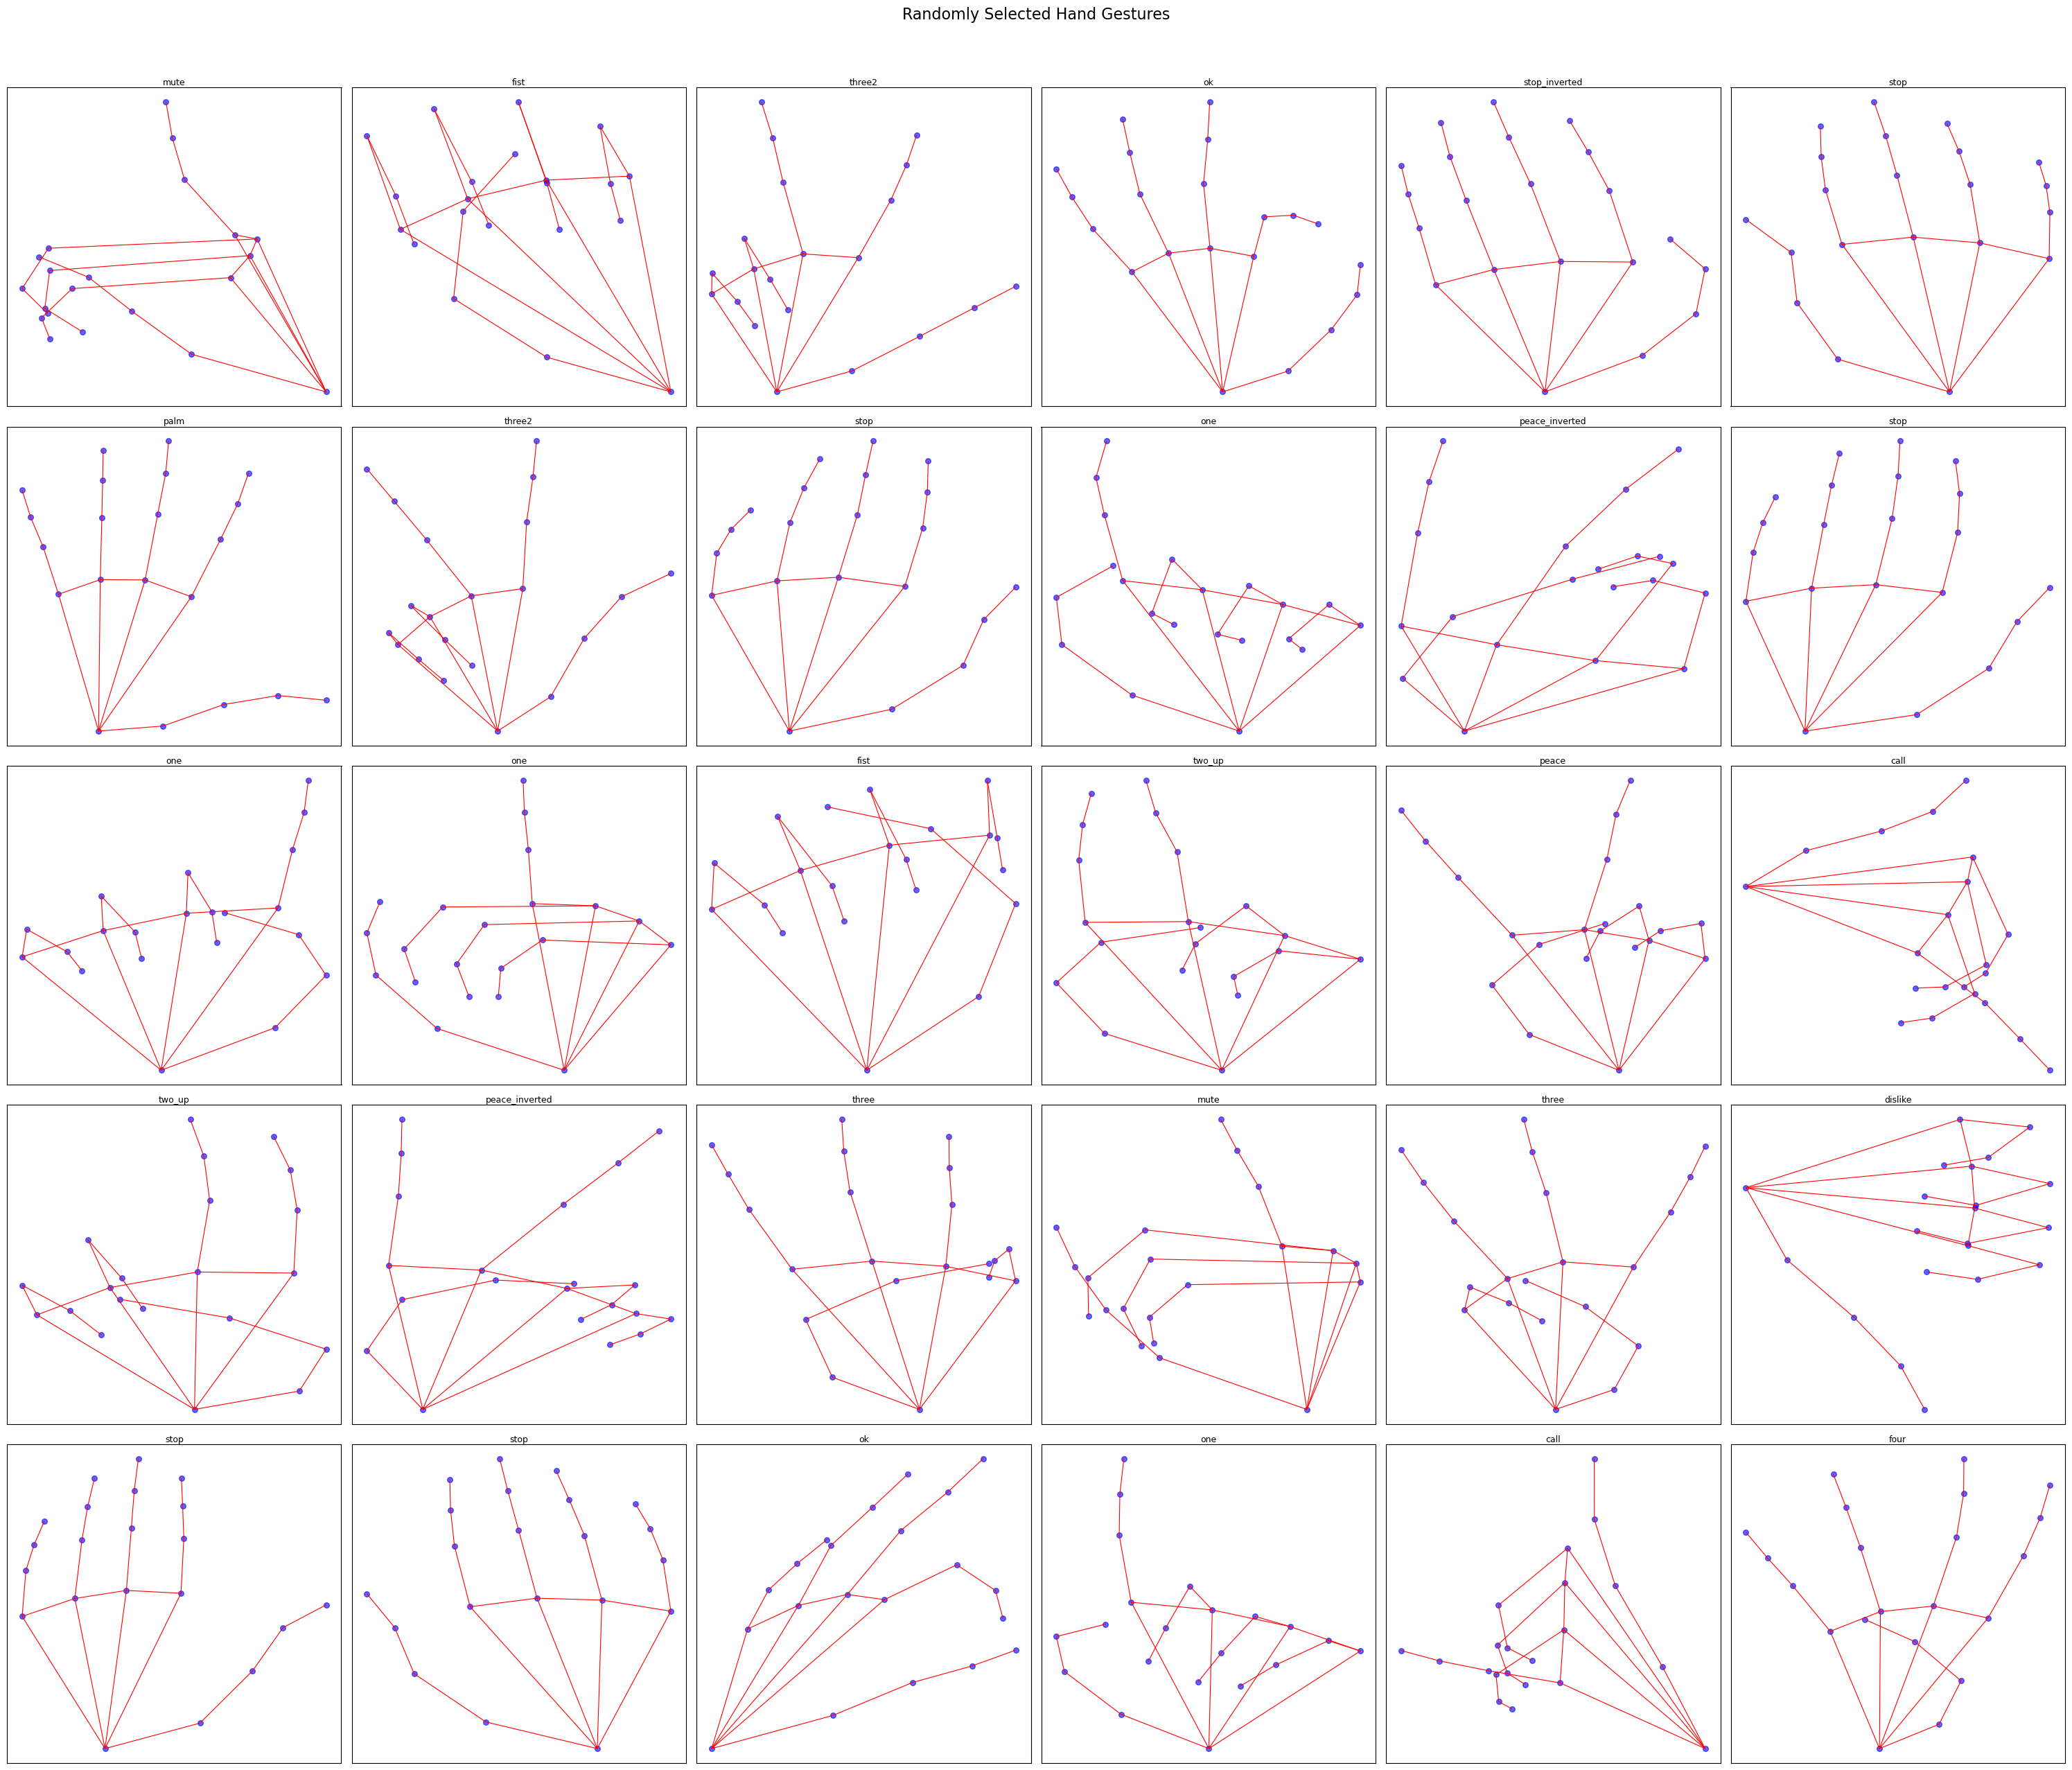

In [44]:
plot_hand_landmarks_subplots(df, n_samples=30, n_rows=5, n_cols=6)

# **Data Preprocessing**

In [45]:
def print_data_dimensions(df):
    """
    Print the dimensions of the DataFrame, including the number of rows and columns.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.shape[1]}")
    print(f"Rows: {df.shape[0]}")

In [46]:
print_data_dimensions(df)

Shape: (25675, 64)
Columns: 64
Rows: 25675


In [47]:
def print_class_distribution(df, column_name='label'):
    """
    Print the distribution of values for a specified column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        column_name (str): The column name to analyze. Default is 'label'.

    Returns:
        None
    """
    print(df[column_name].value_counts())

In [48]:
print_class_distribution(df, column_name='label')

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


In [49]:
def plot_gesture_distribution(df, column_name='label', figsize=(12, 6), palette="rocket"):
    """
    Plot the distribution of gestures by category.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column name to analyze. Default is 'label'.
        figsize (tuple): The size of the figure. Default is (12, 6).
        palette (str): The color palette for the plot. Default is "rocket".

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    ax = sns.countplot(y=column_name, data=df, palette=palette, order=df[column_name].value_counts().index)

    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Gesture Label", fontsize=12)
    plt.title("Gesture Distribution by Category", fontsize=14, pad=20)
    
    # Remove the legend to avoid the warning
    # plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

/var/folders/6q/x7lw66ss2450mnvh0fzn5djm0000gn/T/ipykernel_45488/1565196473.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=column_name, data=df, palette=palette, order=df[column_name].value_counts().index)


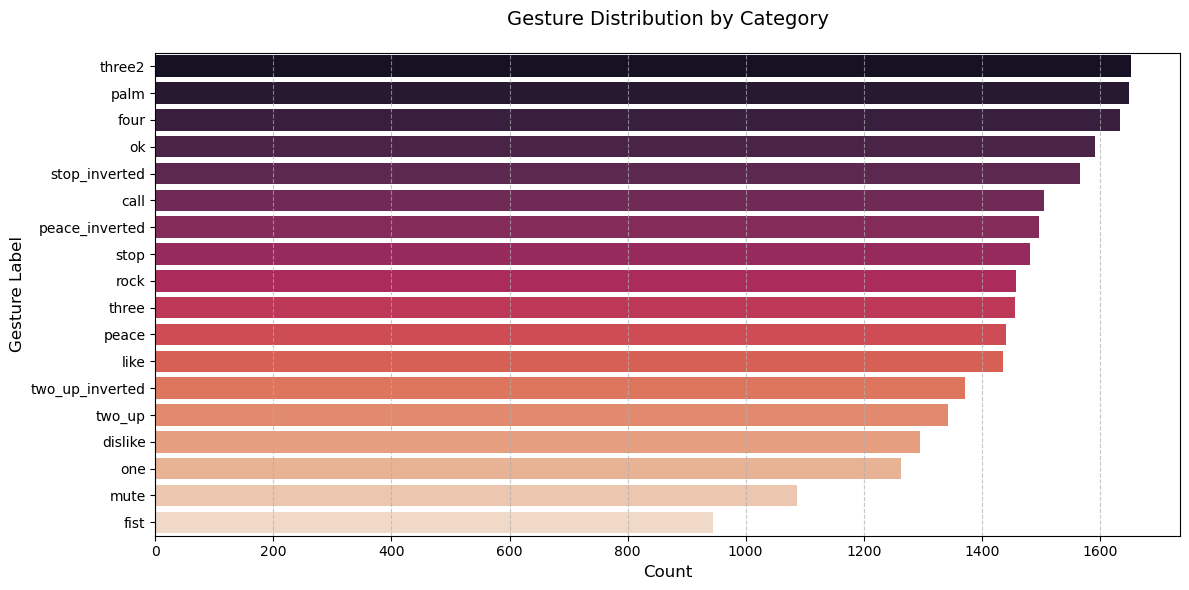

In [50]:
plot_gesture_distribution(df)

In [51]:
def print_dataframe_info(df):
    """
    Print detailed information about the DataFrame, including column data types, 
    non-null counts, and memory usage.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print("DataFrame Information:")
    print("-" * 30)
    print(df.info())

In [52]:
print_dataframe_info(df)

DataFrame Information:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-

In [53]:
def check_null_values(df):
    """
    Check for null values in the DataFrame and print the count of nulls for each column.

    Args:
        df (pd.DataFrame): The DataFrame to check for null values.

    Returns:
        pd.Series: A Series containing the count of null values for each column.
    """
    null_counts = df.isnull().sum()
    print("Null values in each column:")
    print(null_counts)
    return null_counts


In [54]:
null_counts = check_null_values(df)

Null values in each column:
x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64


In [55]:
def check_duplicates(df):
    """
    Check for duplicate rows in the DataFrame and print the count of duplicates.

    Args:
        df (pd.DataFrame): The DataFrame to check for duplicates.

    Returns:
        pd.Series: A boolean Series indicating duplicate rows.
    """
    duplicates = df.duplicated()
    duplicate_count = duplicates.sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    return duplicates

In [56]:
duplicates = check_duplicates(df)

Number of duplicate rows: 0


*   **As shown in cell above there is no null values**
*   **All data is of type float 64 except label is object**







In [57]:
def print_statistical_description(df):
    """
    Print the statistical description of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        pd.DataFrame: The statistical description of the DataFrame.
    """
    
    print("Statistical Description of the DataFrame:")
    print("-" * 50)
    print(df.describe())
    return df.describe()


In [58]:
statistical_description = print_statistical_description(df)

Statistical Description of the DataFrame:
--------------------------------------------------
                 x1            y1            z1            x2            y2  \
count  25675.000000  25675.000000  2.567500e+04  25675.000000  25675.000000   
mean     201.958632    260.158527  1.272461e-07    202.517395    252.115322   
std       90.500333     76.533210  2.737932e-07     84.770933     75.384691   
min      -36.050926     45.722923 -2.029986e-06      7.184681     51.256840   
25%      124.110329    205.815950 -5.243216e-08    130.535929    197.999625   
50%      199.667847    255.181793  1.497277e-07    199.979530    247.113892   
75%      266.428482    304.991663  2.989988e-07    261.147457    296.850769   
max      633.556020    781.674469  1.876254e-06    606.232386    751.869416   

                 z2            x3            y3            z3            x4  \
count  25675.000000  25675.000000  25675.000000  25675.000000  25675.000000   
mean      -0.009465    202.862981    

In [59]:
df

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,259.135620,277.542236,4.323656e-07,271.098221,257.333374,0.007132,269.350250,237.538345,0.004480,257.334503,...,231.102150,230.308350,-0.028861,235.017242,235.029312,-0.016911,237.608711,240.918411,-0.006697,two_up_inverted
25671,90.063995,256.181732,3.808555e-07,77.302231,237.829132,0.003778,78.658888,220.471680,-0.001519,89.374163,...,116.692326,210.932007,-0.043690,112.681984,215.274353,-0.029510,110.178349,221.338379,-0.015630,two_up_inverted
25672,236.724518,251.496756,5.912488e-07,254.918358,232.369956,0.001354,256.002502,209.969106,-0.001674,247.075447,...,211.933777,202.389975,-0.031740,215.493393,208.953272,-0.021970,218.057648,215.236920,-0.010803,two_up_inverted
25673,119.466957,309.842529,4.319564e-07,111.772064,291.310333,0.006174,116.895447,273.683929,0.001893,129.239788,...,157.217422,271.056702,-0.046297,154.780106,277.261139,-0.032800,150.117119,282.011047,-0.020277,two_up_inverted


In [60]:
def plot_coordinate_distributions(df):
    """
    Plot histograms for X, Y, and Z coordinates from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing hand landmark coordinates.

    Returns:
        None
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    # Plot all X, Y, Z coordinates (21 points each)
    sns.histplot(df.filter(like='x').values.ravel(), kde=True, ax=axes[0], bins=30)
    sns.histplot(df.filter(like='y').values.ravel(), kde=True, ax=axes[1], bins=30)
    sns.histplot(df.filter(like='z').values.ravel(), kde=True, ax=axes[2], bins=30)

    # Set titles for each subplot
    axes[0].set_title("X-Coordinates")
    axes[1].set_title("Y-Coordinates")
    axes[2].set_title("Z-Coordinates")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

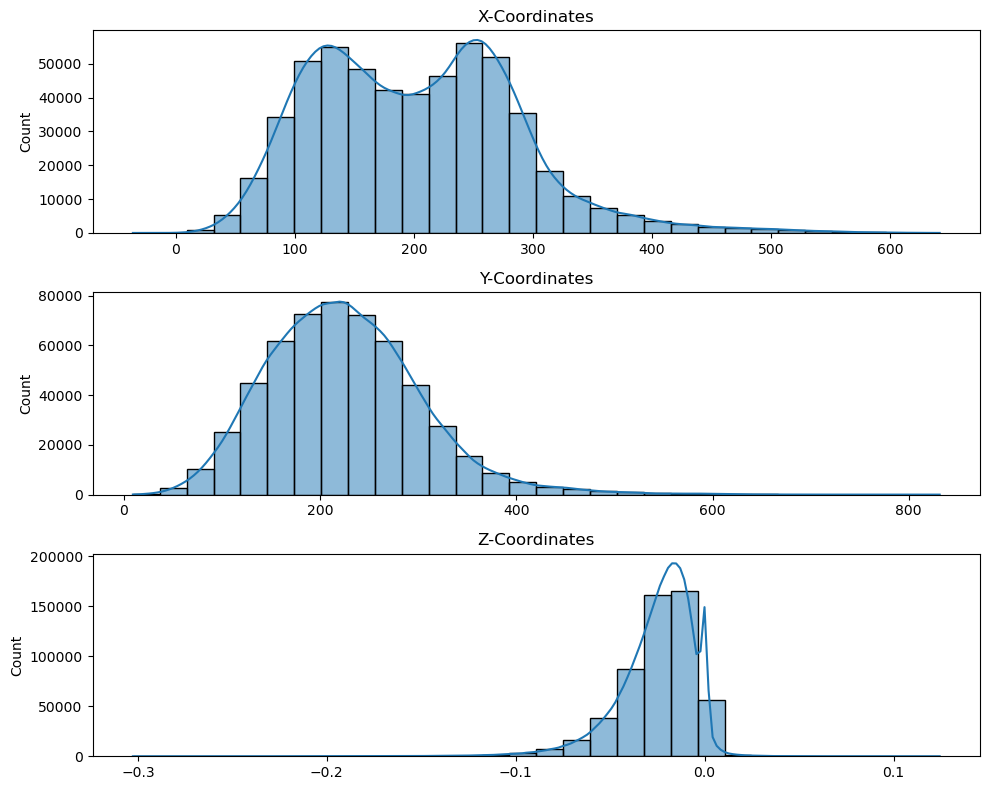

In [61]:
plot_coordinate_distributions(df)



*   **There is skewness in data**
*  **Also from df.describe() i notice coordinates (x, y, z) are on different scales**





In [62]:
def normalize_landmarks(df):
    """
    Normalize hand landmarks by recentering based on the wrist position (x1, y1)
    and scaling based on the distance to the middle finger tip (x13, y13).

    Args:
        df (pd.DataFrame): DataFrame containing hand landmark coordinates.

    Returns:
        pd.DataFrame: Normalized DataFrame.
    """
    # Extract wrist (x1, y1) and middle finger tip (x13, y13)
    wrist_x = df['x1'].values
    wrist_y = df['y1'].values
    middle_tip_x = df['x13'].values
    middle_tip_y = df['y13'].values

    # Compute scaling factor (distance from wrist to middle finger tip)
    scale_factor = np.sqrt((middle_tip_x - wrist_x)**2 + (middle_tip_y - wrist_y)**2)

    # Normalize all (x, y) landmarks (skip z and label columns)
    for i in range(1, 22):  # x1 to x21, y1 to y21
        df[f'x{i}'] = (df[f'x{i}'] - wrist_x) / scale_factor
        df[f'y{i}'] = (df[f'y{i}'] - wrist_y) / scale_factor

    # Verify normalization
    print("Wrist (x1, y1) after normalization:", df[['x1', 'y1']].mean().values)  # Should be [0, 0]
    print("Middle finger tip (x13, y13) distance from wrist:",
          np.sqrt(df['x13']**2 + df['y13']**2).mean())  # Should be ~1.0

    return df

In [63]:
df = normalize_landmarks(df)

Wrist (x1, y1) after normalization: [0. 0.]
Middle finger tip (x13, y13) distance from wrist: 1.0


In [64]:
def plot_coordinate_boxplots(df, figsize=(15, 12)):
    """
    Plot boxplots for X, Y, and Z coordinates from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing hand landmark coordinates.
        figsize (tuple): Size of the figure. Default is (15, 12).

    Returns:
        None
    """
    # Identify columns for X, Y, and Z coordinates
    x_cols = [col for col in df.columns if col.startswith('x')]
    y_cols = [col for col in df.columns if col.startswith('y')]
    z_cols = [col for col in df.columns if col.startswith('z')]

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot boxplots for X, Y, and Z coordinates
    sns.boxplot(data=df[x_cols], ax=axes[0])
    axes[0].set_title("X-Coordinates")

    sns.boxplot(data=df[y_cols], ax=axes[1])
    axes[1].set_title("Y-Coordinates")

    sns.boxplot(data=df[z_cols], ax=axes[2])
    axes[2].set_title("Z-Coordinates")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

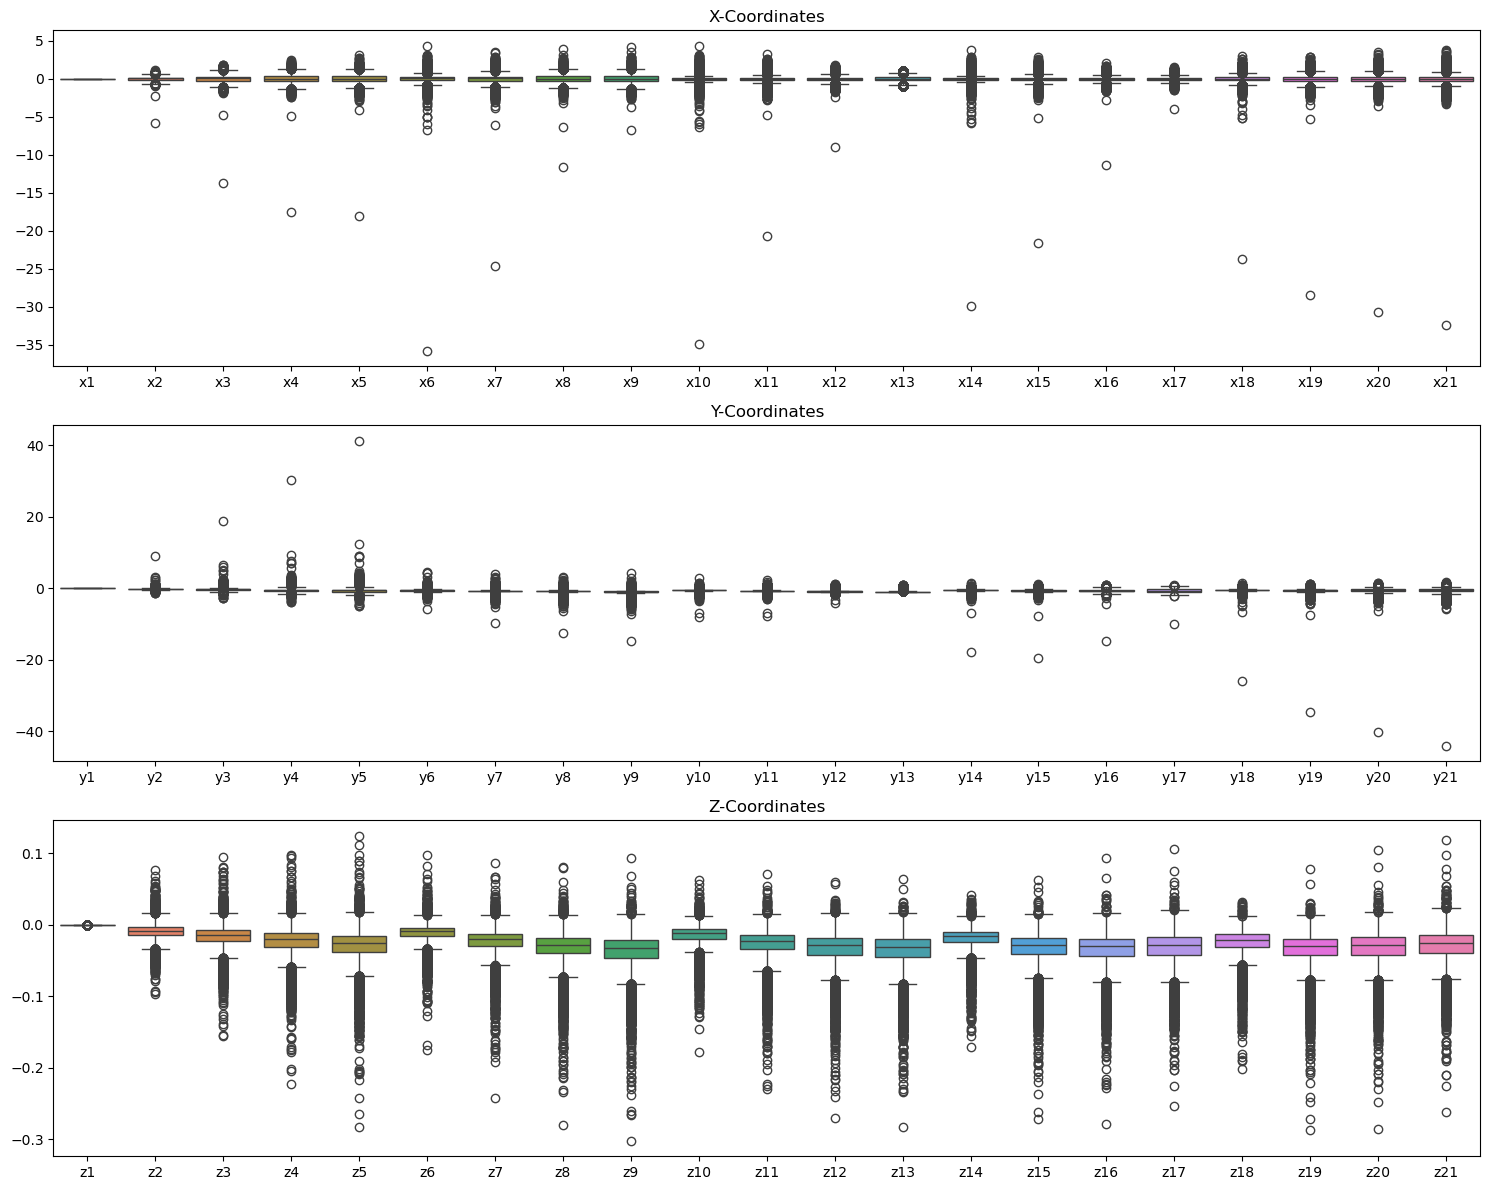

In [65]:
plot_coordinate_boxplots(df)

*   **There is alot of outliers but we can not remove it because it is the nature of data**

* **Natural Variability
Extreme hand poses (e.g., fully stretched fingers or clenched fists) may appear as outliers if the dataset mostly contains neutral poses**







In [66]:
# Step 4: Preprocess Data
def preprocess_data(df):
    X = df.drop(columns=['label'])
    y = df['label']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    with open('label_encoder.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder


In [67]:
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = preprocess_data(df)

# **Model Training**

**Without hyperparameters tuning**

In [68]:
# Model Training
def train_models(X_train, y_train, X_val, y_val):
    print("Training multiple models...")
    print("-" * 30)
    print("Model Training and Validation Accuracies")


    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'KNN': KNeighborsClassifier()
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        report = classification_report(y_val, val_pred, output_dict=True)

        results.append({
            'Model': name,
            'Training Accuracy': train_acc,
            'Validation Accuracy': val_acc,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })

    results_df = pd.DataFrame(results)
    print(results_df.sort_values('Validation Accuracy', ascending=False).to_markdown(index=False, tablefmt="grid"))

    return results_df

In [69]:
results_df = train_models(X_train, y_train, X_val, y_val)

Training multiple models...
------------------------------
Model Training and Validation Accuracies
+---------------------+---------------------+-----------------------+-------------+----------+------------+
| Model               |   Training Accuracy |   Validation Accuracy |   Precision |   Recall |   F1-Score |
+=====================+=====================+=======================+=============+==========+============+
| XGBoost             |            1        |              0.982636 |    0.982758 | 0.982636 |   0.982656 |
+---------------------+---------------------+-----------------------+-------------+----------+------------+
| KNN                 |            0.980526 |              0.978903 |    0.979107 | 0.978903 |   0.978925 |
+---------------------+---------------------+-----------------------+-------------+----------+------------+
| Random Forest       |            1        |              0.975982 |    0.976233 | 0.975982 |   0.976016 |
+---------------------+-------------

# **Hyperparameters Tuning**

**SVM Tuning**

In [70]:
def tune_svm(X_train, y_train):
    """
    Perform hyperparameter tuning for an SVM model using RandomizedSearchCV.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training labels.

    Returns:
        best_svm (SVC): The best SVM model after hyperparameter tuning.
        best_params (dict): The best hyperparameters for the SVM model.
        best_score (float): The best cross-validation score achieved during tuning.
    """
    print("Tuning SVM...")
    print("-" * 30)
    
    # Define the SVM model and parameter grid
    model = SVC(kernel='rbf', probability=True, random_state=42)
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    # Perform RandomizedSearchCV
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    
    # Fit the search to the training data
    search.fit(X_train, y_train)
    
    # Extract the best model, parameters, and score
    best_svm = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_
    
    # Print the results
    print("SVM Best Parameters:", best_params)
    print("SVM Best CV Score:", best_score)
    
    return best_svm, best_params, best_score

In [71]:
best_svm, best_params, best_score = tune_svm(X_train, y_train)

Tuning SVM...
------------------------------
SVM Best Parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
SVM Best CV Score: 0.9859506077281248


**Logistic Regression Tuning**

In [72]:
def tune_logistic_regression(X_train, y_train):
    """
    Tunes a Logistic Regression model using GridSearchCV.
    
    Parameters:
        X_train (array-like): Feature matrix for training.
        y_train (array-like): Target labels for training.
    
    Returns:
        best_model: Best LogisticRegression model found.
        best_params (dict): Best hyperparameters.
        best_score (float): Best cross-validation accuracy.
    """
    print("Tuning Logistic Regression...")
    print("-" * 30)

    model = LogisticRegression(max_iter=5000, random_state=42)

    param_grid = {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    search = GridSearchCV(model,
                          param_grid,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1)

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print("Logistic Regression Best Parameters:", best_params)
    print("Logistic Regression Best CV Score:", best_score)

    return best_model, best_params, best_score

In [73]:
best_model_lr, best_params_lr, best_score_lr = tune_logistic_regression(X_train, y_train)

Tuning Logistic Regression...
------------------------------


Logistic Regression Best Parameters: {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Best CV Score: 0.953818129043962


In [74]:
print("Best Logistic Regression Model:", best_model_lr)

Best Logistic Regression Model: LogisticRegression(C=1000.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')


**Conculsion**

Selecting best model


Final Trial

In [75]:
def evaluate_models(models, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates multiple classification models.

    Parameters:
        models (dict): Dictionary of model name -> model instance.
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_val (array-like): Validation features.
        y_val (array-like): Validation labels.

    Returns:
        results_df (pd.DataFrame): DataFrame containing evaluation metrics.
        best_model_name (str): Name of the best performing model.
        best_model: Best performing model instance.
    """
    results = []

    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # 1. Fit the model
        print(f"Fitting {name} model...")
        model.fit(X_train, y_train)
        
        # 2. Make predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        # 3. Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        report = classification_report(y_val, val_pred, output_dict=True)
        
        results.append({
            'Model': name,
            'Training Accuracy': train_acc,
            'Validation Accuracy': val_acc,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })
        
        print(f"{name} training accuracy: {train_acc:.4f}")
        print(f"{name} validation accuracy: {val_acc:.4f}")

    # Create and display results
    results_df = pd.DataFrame(results)
    print("\nFinal Model Performance Comparison:")
    print(results_df.to_markdown(index=False, tablefmt="grid"))

    # Select best model
    best_model_name = results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Model']
    best_model = models[best_model_name]
    print(f"\nBest model: {best_model_name} (Val Accuracy: {results_df['Validation Accuracy'].max():.4f})")

    return results_df, best_model_name, best_model

In [76]:
best_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': best_svm,
    'Logistic Regression': best_model_lr
}

In [77]:
results_df, best_model_name, best_model = evaluate_models(best_models, X_train, y_train, X_val, y_val)


Evaluating XGBoost...
Fitting XGBoost model...


XGBoost training accuracy: 1.0000
XGBoost validation accuracy: 0.9826

Evaluating KNN...
Fitting KNN model...
KNN training accuracy: 0.9805
KNN validation accuracy: 0.9789

Evaluating Random Forest...
Fitting Random Forest model...
Random Forest training accuracy: 1.0000
Random Forest validation accuracy: 0.9760

Evaluating SVM...
Fitting SVM model...
SVM training accuracy: 0.9947
SVM validation accuracy: 0.9860

Evaluating Logistic Regression...
Fitting Logistic Regression model...
Logistic Regression training accuracy: 0.9608
Logistic Regression validation accuracy: 0.9554

Final Model Performance Comparison:
+---------------------+---------------------+-----------------------+-------------+----------+------------+
| Model               |   Training Accuracy |   Validation Accuracy |   Precision |   Recall |   F1-Score |
+=====================+=====================+=======================+=============+==========+============+
| XGBoost             |            1        |            

In [78]:
def evaluate_on_test_set(models, X_test, y_test):
    """
    Evaluates a dictionary of models on the test set.

    Parameters:
        models (dict): Dictionary of model name -> model instance.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.

    Returns:
        test_results_df (pd.DataFrame): DataFrame with model names and test accuracies.
        best_test_model_info (dict): Dictionary containing name and accuracy of the best test model.
    """
    print("\nTest Accuracy for Each Model:")
    print("-" * 50)

    results = []

    for model_name, model in models.items():
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'Test Accuracy': f"{test_acc:.4f}"
        })

        print(f"{model_name}: {test_acc:.4f}")

    print("\nTest Accuracy Summary:")
    print("-" * 50)
    test_results_df = pd.DataFrame(results)
    print(test_results_df.to_markdown(index=False, tablefmt="grid"))

    # Identify the best model
    if results and all('Error' not in res['Test Accuracy'] for res in results):
        best_test_model = max(results, key=lambda x: float(x['Test Accuracy']))
        print(f"\nBest model on test set: {best_test_model['Model']} with accuracy {best_test_model['Test Accuracy']}")
    else:
        best_test_model = None

    return test_results_df, best_test_model

In [79]:
test_results_df, best_test_model_info = evaluate_on_test_set(best_models, X_test, y_test)


Test Accuracy for Each Model:
--------------------------------------------------
XGBoost: 0.9797
KNN: 0.9698
Random Forest: 0.9731
SVM: 0.9852
Logistic Regression: 0.9566

Test Accuracy Summary:
--------------------------------------------------
+---------------------+-----------------+
| Model               |   Test Accuracy |
+=====================+=================+
| XGBoost             |          0.9797 |
+---------------------+-----------------+
| KNN                 |          0.9698 |
+---------------------+-----------------+
| Random Forest       |          0.9731 |
+---------------------+-----------------+
| SVM                 |          0.9852 |
+---------------------+-----------------+
| Logistic Regression |          0.9566 |
+---------------------+-----------------+

Best model on test set: SVM with accuracy 0.9852


**Load Model**

In [86]:
with open('best_model_svm.pkl', 'wb') as file:
    pickle.dump(best_model, file)  # Save the actual trained model

print("Best model saved as 'best_model_svm.pkl'.")  


Best model saved as 'best_model_svm.pkl'.


In [108]:
def load_and_predict():

    svm_model = pickle.load(open("best_model.pkl", "rb"))
    label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

    cap = cv2.VideoCapture(0)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter("output.mp4", fourcc, 30, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_frame)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                wrist_x, wrist_y, wrist_z = landmarks[0]
                landmarks[:, 0] -= wrist_x
                landmarks[:, 1] -= wrist_y

                mid_finger_x, mid_finger_y, _ = landmarks[12]
                scale_factor = np.sqrt(mid_finger_x**2 + mid_finger_y**2)
                landmarks[:, 0] /= scale_factor
                landmarks[:, 1] /= scale_factor

                features = landmarks.flatten().reshape(1, -1)
                numeric_prediction = svm_model.predict(features)[0]
                label_prediction = label_encoder.inverse_transform([numeric_prediction])[0]

                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.putText(frame, f'Prediction: {label_prediction}', (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        out.write(frame)
        cv2.imshow("Hand Gesture Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [127]:
load_and_predict()

I0000 00:00:1743867375.543789  270196 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1743867375.567222 1005393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743867375.578243 1005391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
